# Telecommunication_user_churn_classifier


## 1. Data Mining


In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
print("Libraries imported successfully.....")
#Importing data
df = pd.read_csv("telecom_customer_churn.csv")

#print("Data imported successfully.....")


In [ ]:
# Remove the columns "Customer Status", "Churn Category", and "Churn Reason"
columns_to_remove = ["Customer Status", "Churn Category", "Churn Reason"]
df_train = df.drop(columns=columns_to_remove)

# Take out 30% of the DataFrame as the test set
test_size = 0.3
df_test = df_train.sample(frac=test_size, random_state=42)
df = df.drop(index=df_test.index)


## 2. Data Cleaning and EDA


In [ ]:
#Separate numerical and categorical columns

from preprolib import myfunctions
num_cols = []
cat_cols = []

ignore_list = ['Zip Code', 'Longitude', 'Latitude', 
                'Customer ID', 'Churn Category', 
                'Churn Reason', 'Customer Status', 'City']

myfunctions.cat_or_num(df, ignore_list, num_cols, cat_cols)

label = 'Customer Status'


## 2.1 Exploratory Data Analysis
### 2.1.1 Numerical data


In [ ]:
# Calculate the value counts for each 'Customer Status'
Customer_status_counts = df['Customer Status'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(Customer_status_counts, labels=Customer_status_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Customer Status Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [ ]:
# Box plots for numerical data
for column in num_cols:
    plt.figure()  # Create a new figure for each box plot
    sns.boxplot(x='Customer Status', y=column, data=df)
    plt.title(f'Box Plot for {column} against {"Customer Status"}')
    plt.ylabel(column)
    plt.xlabel('Target')
    plt.show()

num_cols


Inferences notes in readme
### 2.1.2 Categorical data

  



In [ ]:
# Group by 'Customer Status' and each categorical column, and get value counts for each category
for col in cat_cols:
    plt.figure(figsize=(12, 6))
    plt.title(f"Value Counts for '{col}' - Grouped by Customer Status")

    # Group the data by 'Customer Status' and the current column, and get value counts for each category
    group_counts = df.groupby(['Customer Status', col]).size().unstack()

    # Plot the grouped bar chart
    sns.barplot(data=group_counts.reset_index().melt(id_vars='Customer Status', value_name='Count'),
                x=col, y='Count', hue='Customer Status', palette='pastel')

    # Set labels and legend
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Customer Status', title_fontsize='large', fontsize='large')

    plt.tight_layout()
    plt.show()
    


### 2.2 Data preprocessing


In [ ]:
##num_cols.remove

remove_num = ['Age', 'Avg Monthly Long Distance Charges',  'Avg Monthly GB Download', 'Monthly Charge']

num_cols = [x for x in num_cols if x not in remove_num]


##cat_cols.remove

remove_cat = ['Age', 'Avg Monthly Long Distance Charges',  'Avg Monthly GB Download', 'Monthly Charge']

cat_cols = [x for x in cat_cols if x not in remove_cat]


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Define the features and label
features = cat_cols + num_cols
label = 'Customer Status'

# Convert the label column to ordinal categories
label_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
y = label_encoder.fit_transform(df[label].values.reshape(-1, 1))

# Function to encode based on the percentage of churn per category
def custom_encode(column, churn_column):
    churn_percentage = df.groupby(column)[churn_column].mean()
    return churn_percentage.rank().fillna(0).astype(int)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.3, random_state=0)

# Define a pipeline for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Define a pipeline for categorical columns
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Create a ColumnTransformer to apply the pipeline to the numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Fit the preprocessor to the training data and transform both the training and test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print('Training Set: %d, Test Set: %d \n' % (len(X_train), len(X_test)))

# Print the transformed DataFrames
print("X_train_Transformed:\n", X_train_transformed)
print("\nX_test_Transformed:\n", X_test_transformed)


# Create a dictionary to map encoded variables to original labels
label_mapping = {}
for i, label in enumerate(label_encoder.categories_[0]):
    label_mapping[i] = label

# Print the dictionary
print("Encoded to Original Label Mapping:")
print(label_mapping)


## 3. Model Selection


In [ ]:
#Import classifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier().fit(X_train_transformed, y_train)  # Convert one-hot encoded y_train to 1D array


#Model evaluation
#from preprolib.myfunctions import evaluate_model

#evaluate_model(rf_model,X_test_transformed, y_test)



In [ ]:
def evaluate_model(curr_model, X_test, y_test):
    import pandas as pd
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    #Convert the one-hot encoded y_test to a 1-dimensional array
    y_test = y_test

    predictions = curr_model.predict(X_test)


    #Calculate the necessary metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    #Print the results for the current model
    print("Model Evaluation:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

evaluate_model(rf_model,X_test_transformed, y_test)


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with 5 folds (you can adjust the number of folds as needed)

cv_scores = cross_val_score(rf_model, X_train_transformed, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Average Cross-validation Accuracy:", cv_scores.mean())


In [ ]:
import joblib

# Save the model to a file
joblib.dump(rf_model, 'trained_rf_model.pkl')

print("Model saved successfully.")



In [ ]:
# Load the model from the file
loaded_rf_model = joblib.load('trained_rf_model.pkl')

# Transform the test data using the preprocessor
df_test_transformed = preprocessor.transform(df_test)

# Make predictions on the test data using the loaded model
test_pred = loaded_rf_model.predict(df_test_transformed)

# Reshape the test_pred array to a 2D array
test_pred_2d = test_pred.reshape(-1, 1)

# Map the predicted values back to their original labels
predicted_labels = label_encoder.inverse_transform(test_pred_2d)

# Print the predicted labels
print("Predicted Labels:")
print(predicted_labels)



In [ ]:
# Create a new DataFrame with the predicted labels
predicted_df = pd.DataFrame(predicted_labels, columns=['Predicted_Customer_Status'])

# Concatenate the predicted_df with df_test
df_test_with_predictions = pd.concat([df_test, predicted_df], axis=1)

# Print the DataFrame with the predicted labels
print(df_test_with_predictions)


# Churn Reason Anaysis

In [ ]:
df_reason = df[df['Customer Status'] == 'Churned']
df_reason 


In [ ]:
#Separate numerical and categorical columns

num_cols_res = []
cat_cols_res = []

ignore_list = ['Zip Code', 'Longitude', 'Latitude', 
                'Customer ID', 'Churn Category', 
                'Churn Reason', 'Customer Status', 'City']

myfunctions.cat_or_num(df_reason, ignore_list, num_cols_res, cat_cols_res)

label = 'Customer Status'


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

# Define the imputer
imputer = SimpleImputer(strategy='most_frequent')  # You can choose the strategy as per your requirement

# Define the column transformer
preprocessor = make_column_transformer((imputer, df_reason.columns))

# Fit and transform the DataFrame through the pipeline
df_transformed = preprocessor.fit_transform(df_reason)

# Convert the transformed array back to a DataFrame
df_transformed = pd.DataFrame(df_transformed, columns=df_reason.columns)

# Set the data types of the columns to match the original DataFrame
for col in df_reason.columns:
    df_transformed[col] = df_transformed[col].astype(df_reason[col].dtype)

# Display the transformed DataFrame
print(df_transformed)


In [ ]:
df_reason = df_transformed


In [ ]:
# Check for null values in categorical columns
for col in cat_cols_res:
    null_count = df_reason[col].isnull().sum()
    print(f"Number of null values in '{col}': {null_count}")


In [ ]:
# Check for null values in categorical columns
for col in num_cols_res:
    null_count = df_reason[col].isnull().sum()
    print(f"Number of null values in '{col}': {null_count}")


In [ ]:
# Calculate the value counts for each 'Churn Category'
churn_category_counts = df_reason['Churn Category'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(churn_category_counts, labels=churn_category_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Churn Category Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


In [ ]:
# Box plots for numerical data
for column in num_cols_res:
    plt.figure()  # Create a new figure for each box plot
    sns.boxplot(x='Churn Category', y=column, data=df_reason)
    plt.title(f'Box Plot for {column} against {"Churn Category"}')
    plt.ylabel(column)
    plt.xlabel('Target')
    plt.show()

num_cols

In [ ]:
# Group by 'Churn Category' and each categorical column, and get value counts for each category
for col in cat_cols_res:
    plt.figure(figsize=(12, 6))
    plt.title(f"Value Counts for '{col}' - Grouped by Churn Category")

    # Group the data by 'Churn Category' and the current column, and get value counts for each category
    group_counts = df_reason.groupby(['Churn Category', col]).size().unstack()

    # Sort the values in each category based on their counts in descending order
    group_counts_sorted = group_counts.apply(lambda x: x.sort_values(ascending=False), axis=1)

    # Plot the grouped bar chart
    sns.barplot(data=group_counts_sorted.reset_index().melt(id_vars='Churn Category', value_name='Count'),
                x=col, y='Count', hue='Churn Category', palette='pastel')

    # Set labels and legend
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Churn Category', title_fontsize='large', fontsize='large')

    plt.tight_layout()
    plt.show()

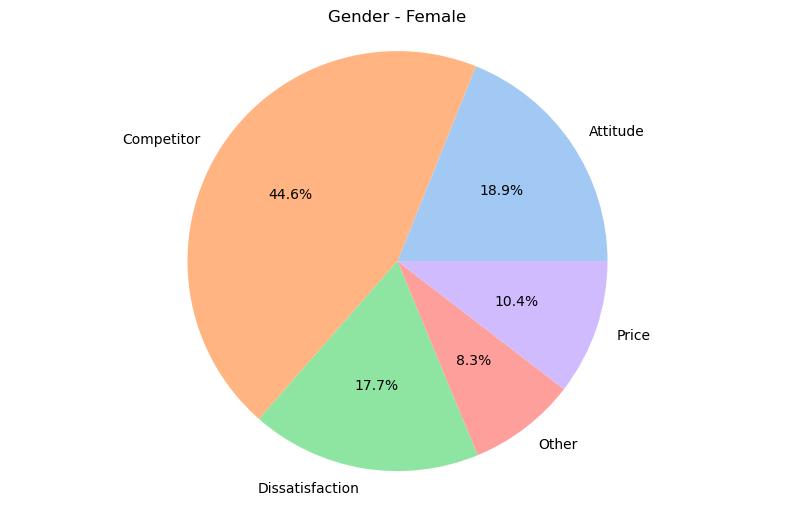

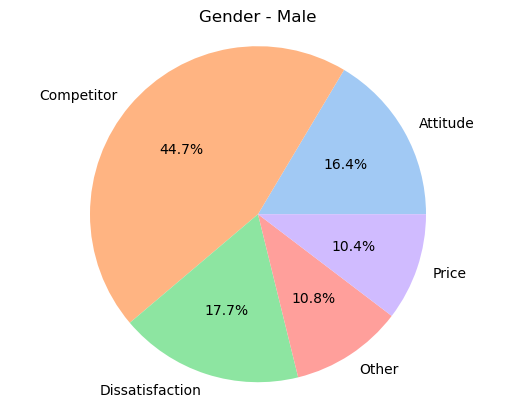

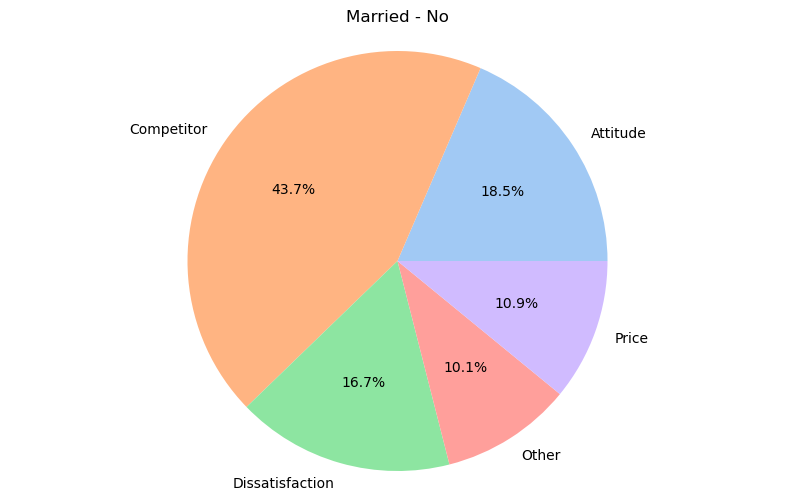

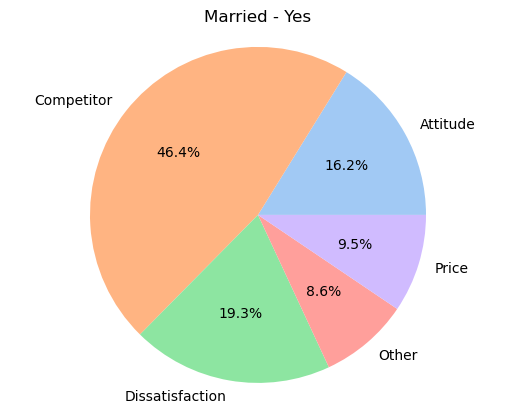

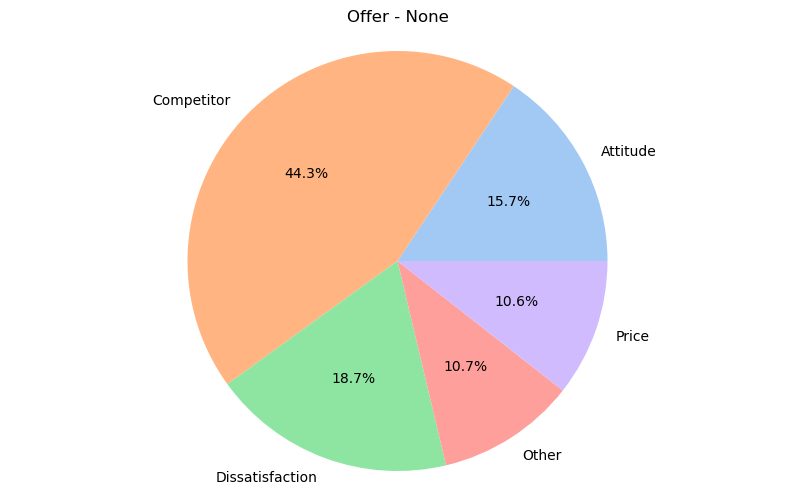

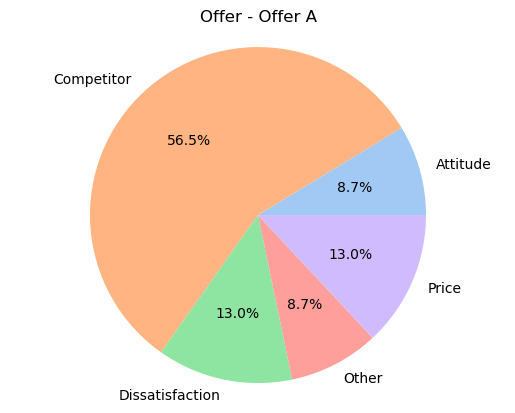

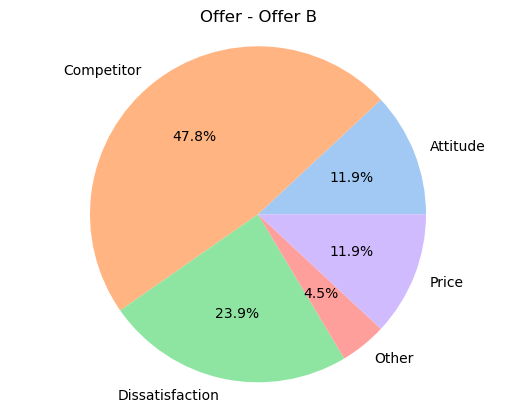

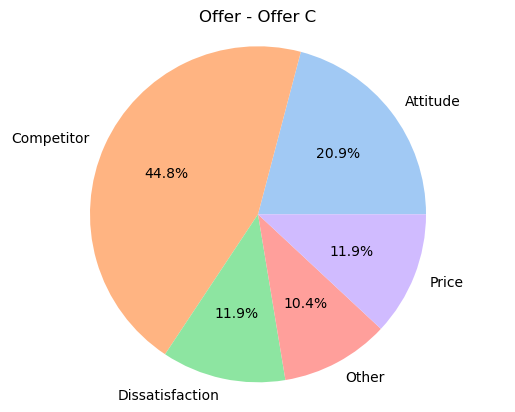

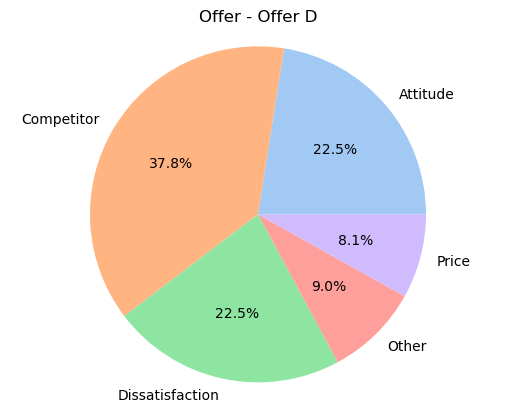

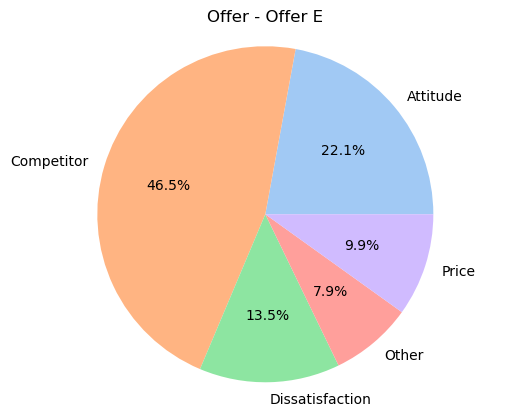

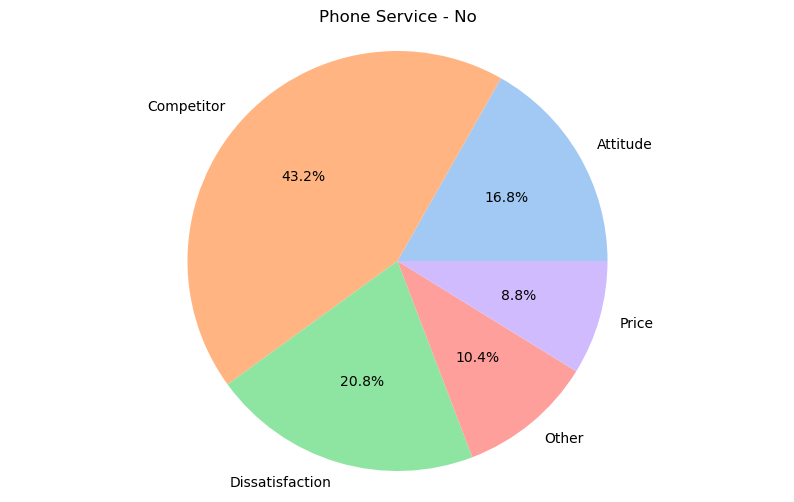

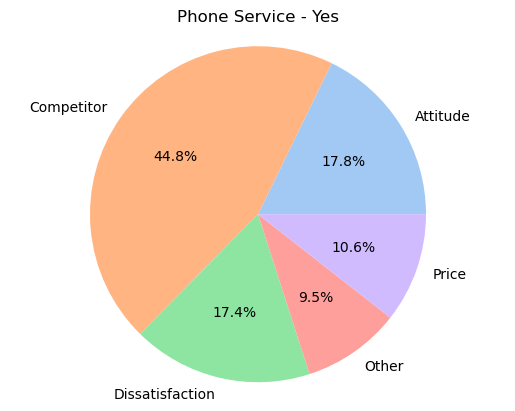

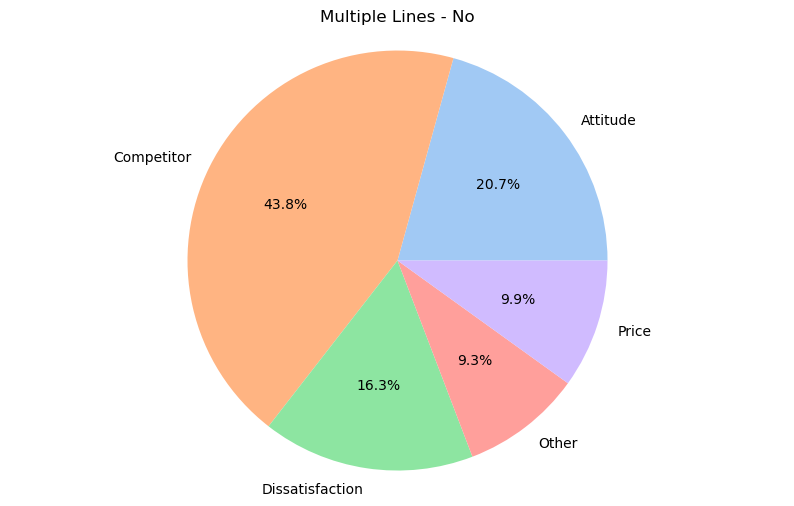

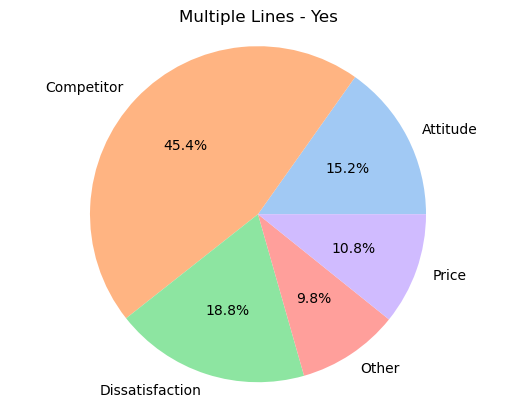

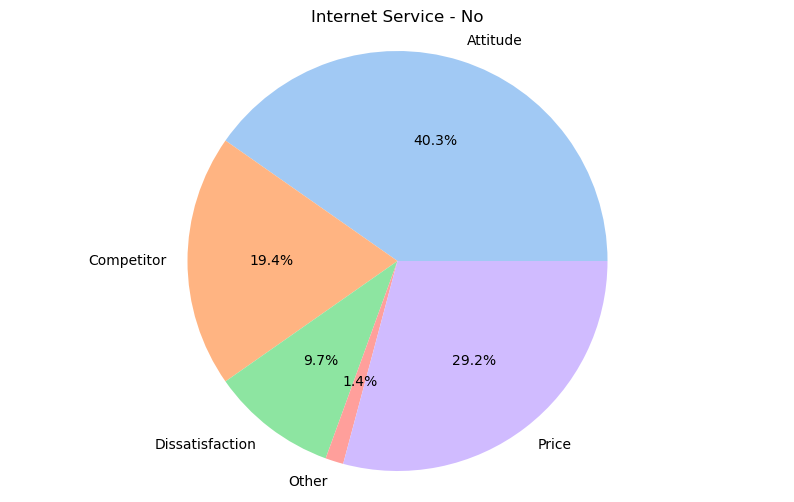

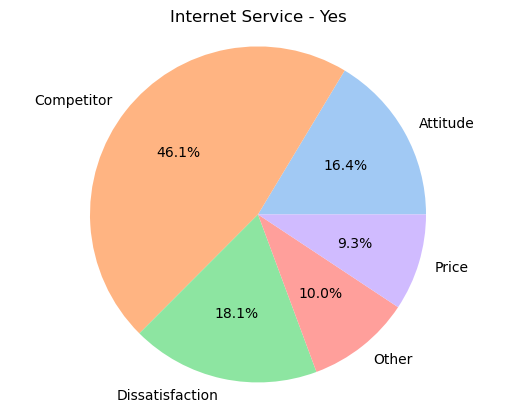

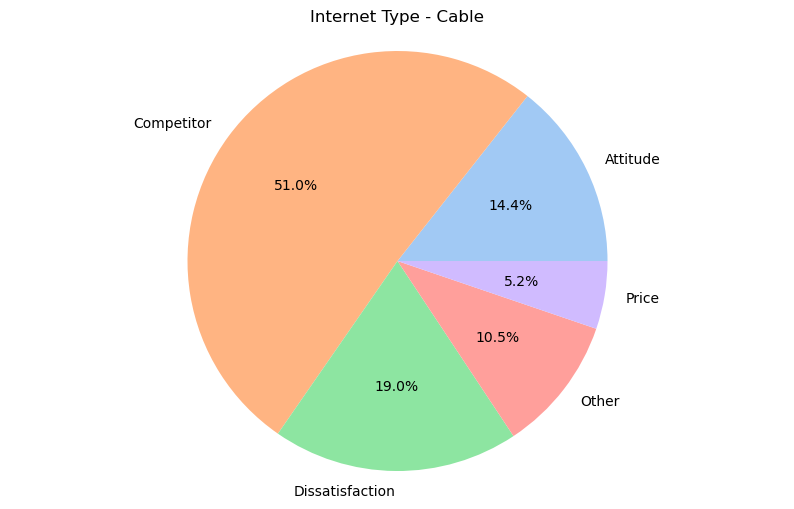

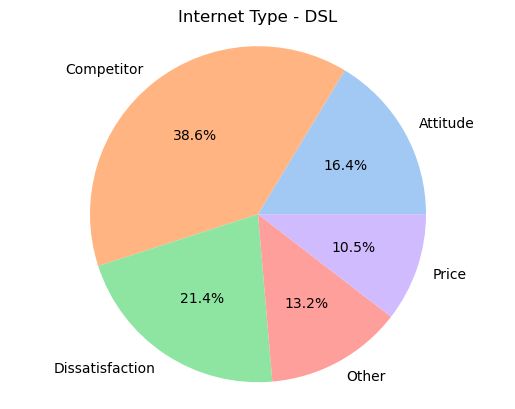

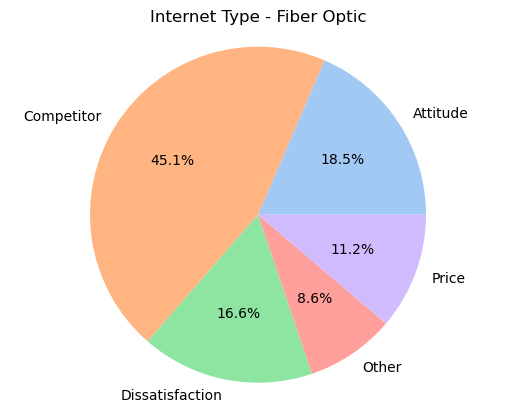

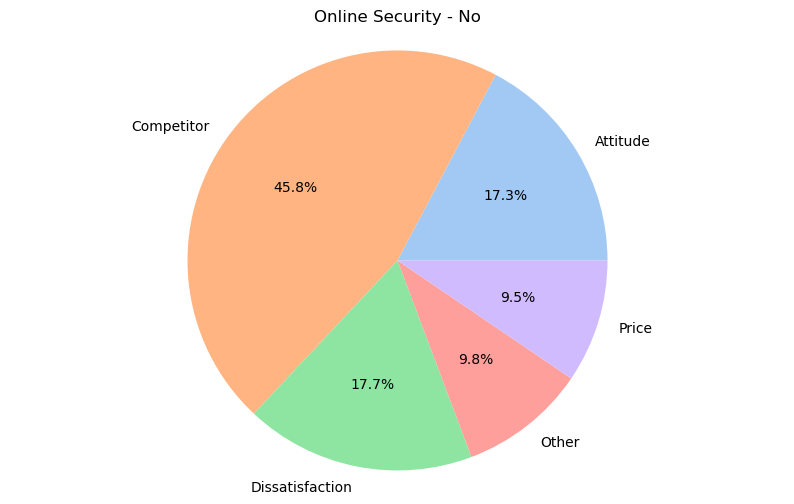

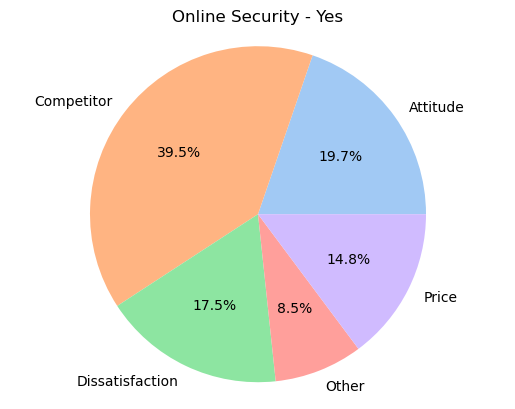

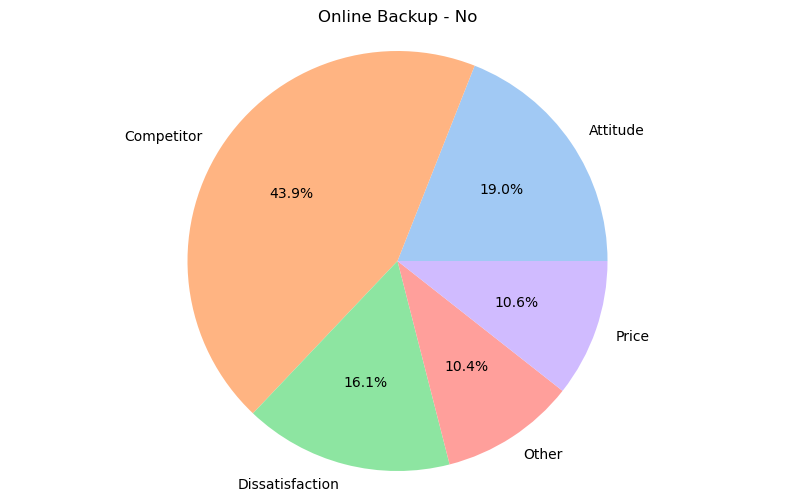

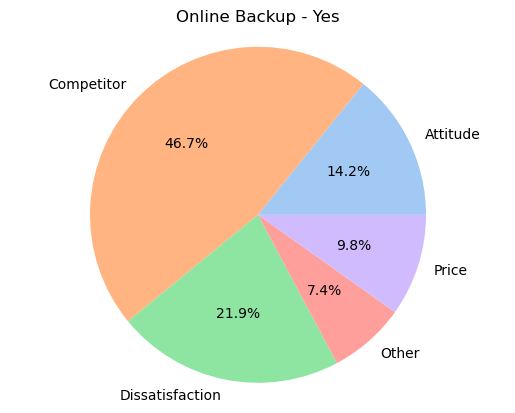

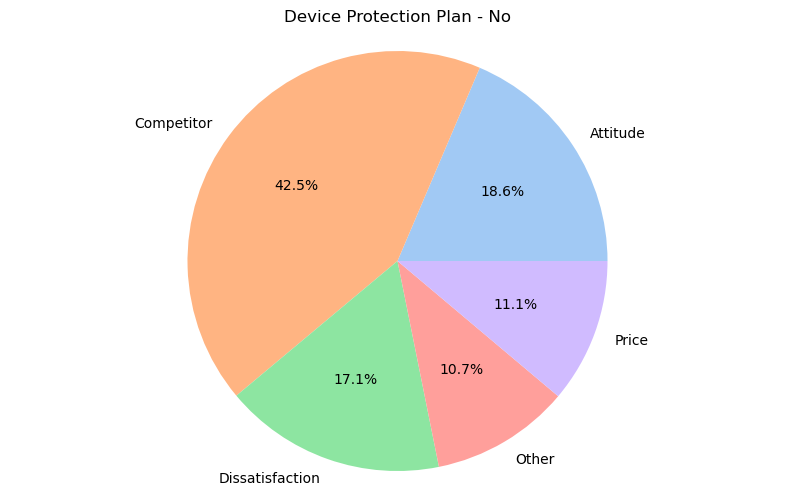

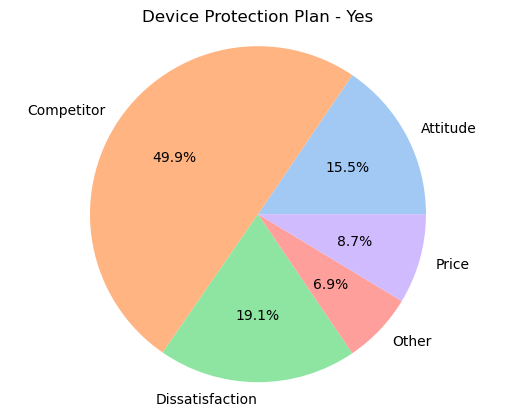

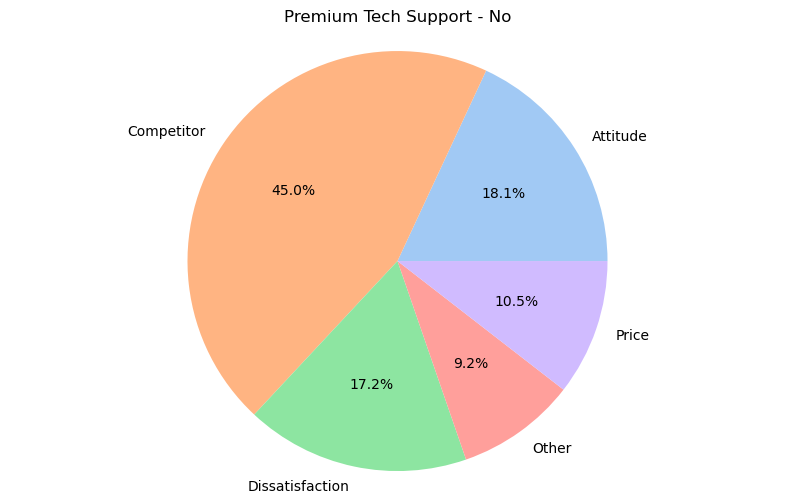

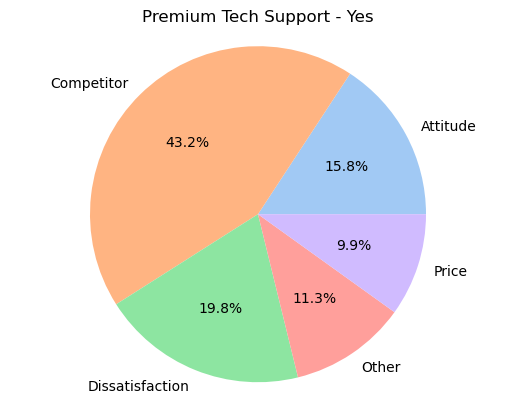

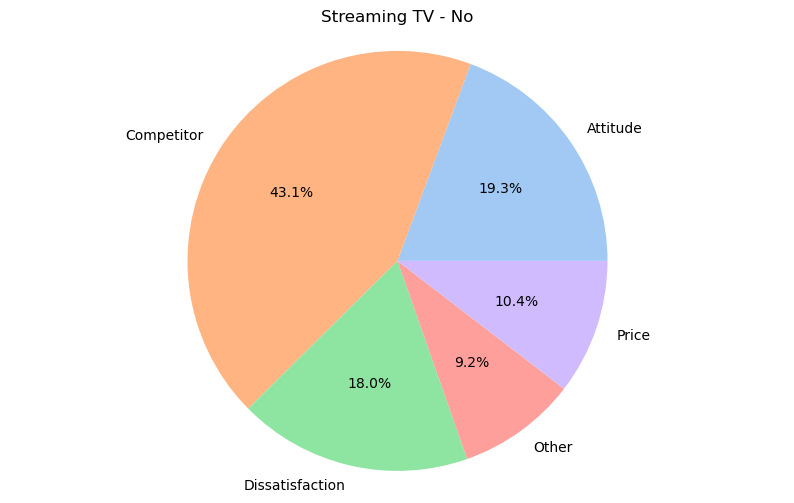

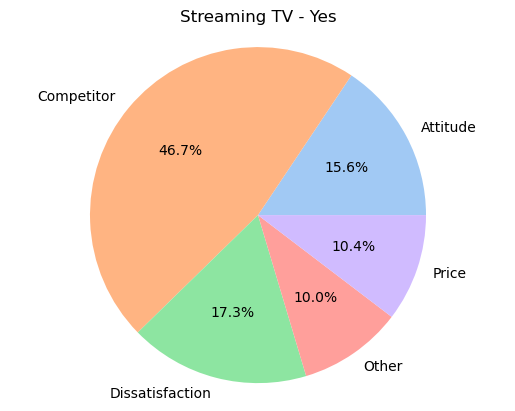

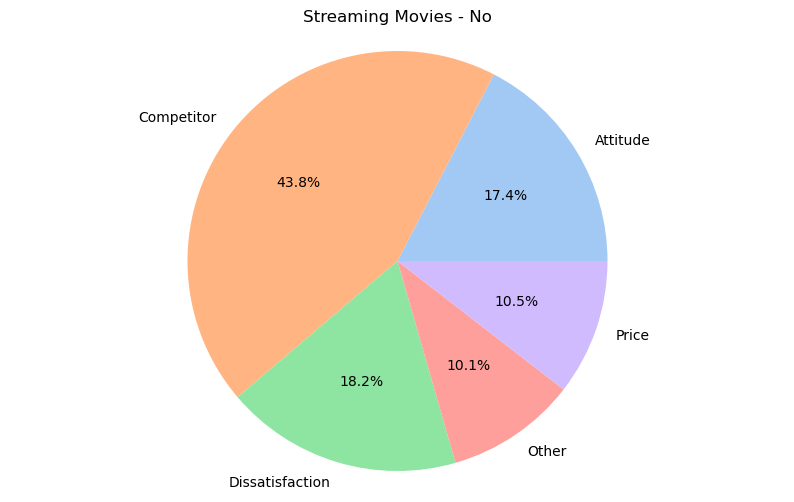

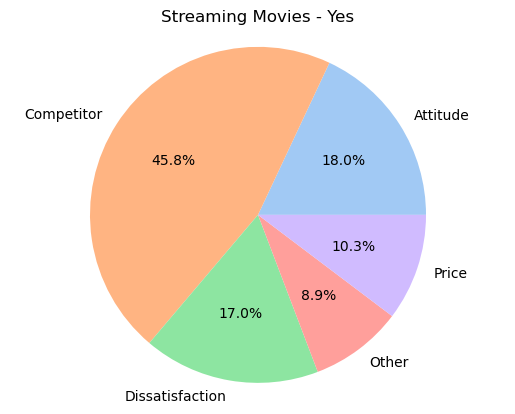

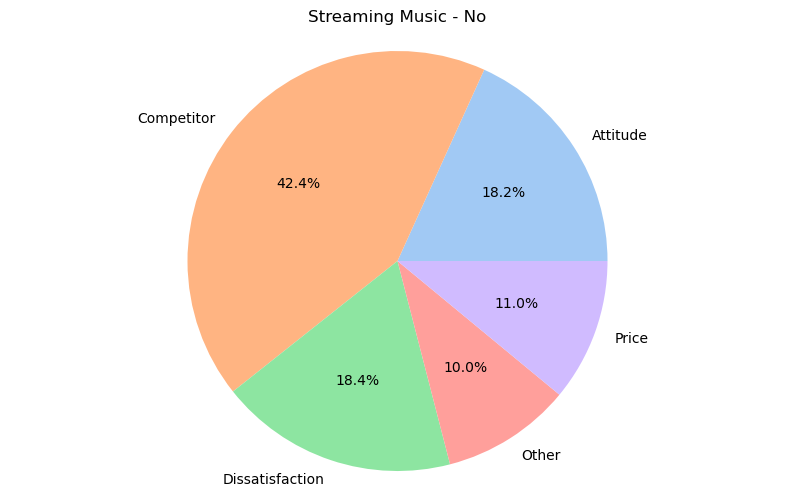

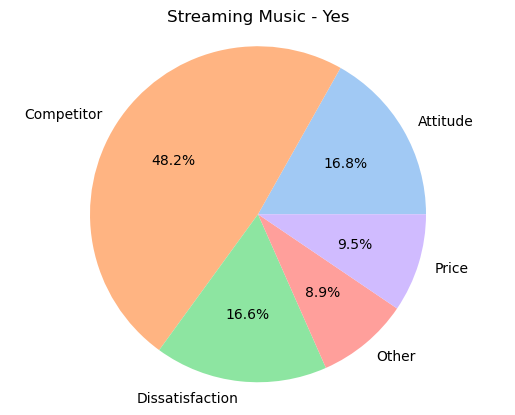

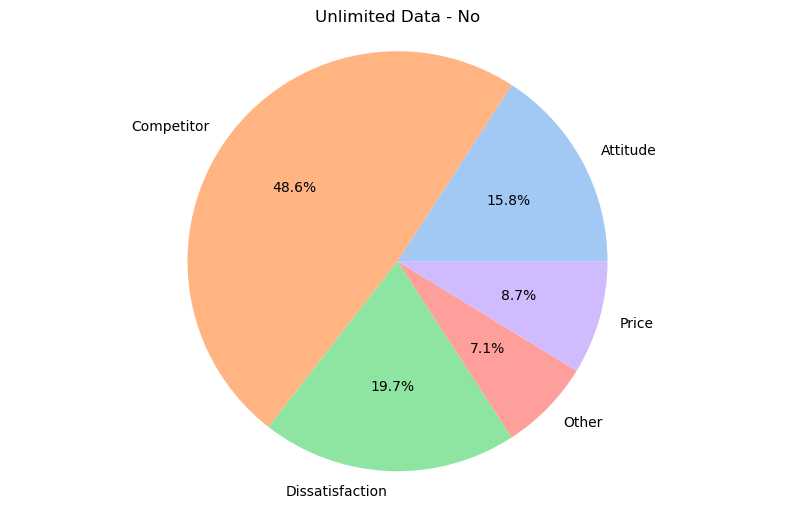

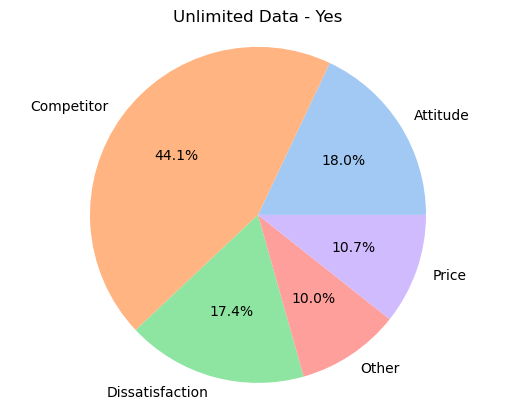

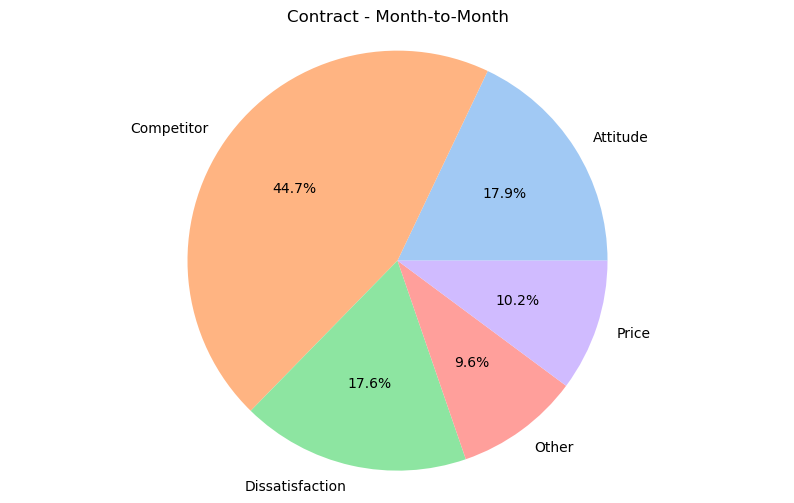

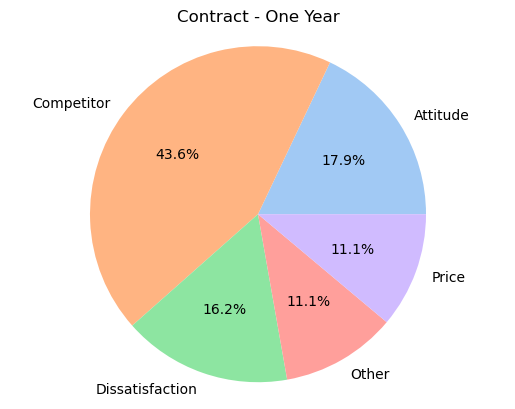

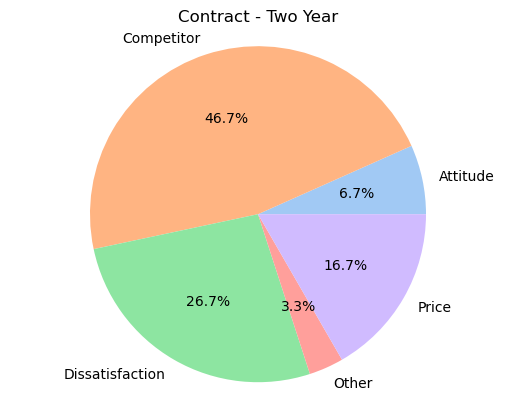

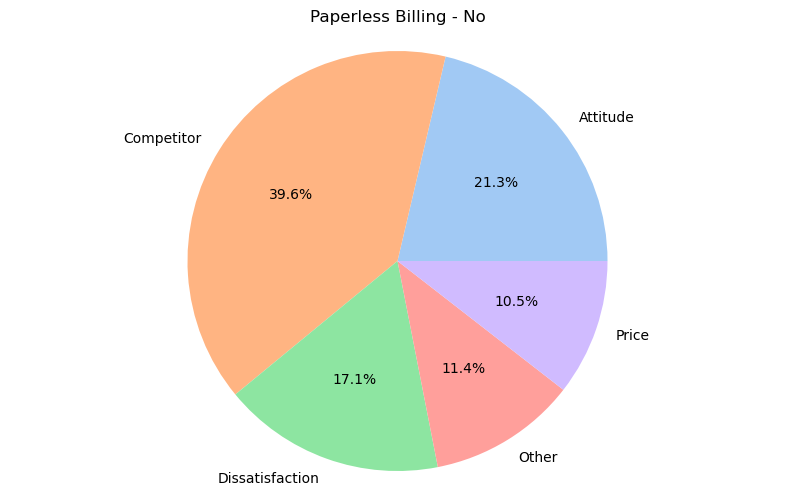

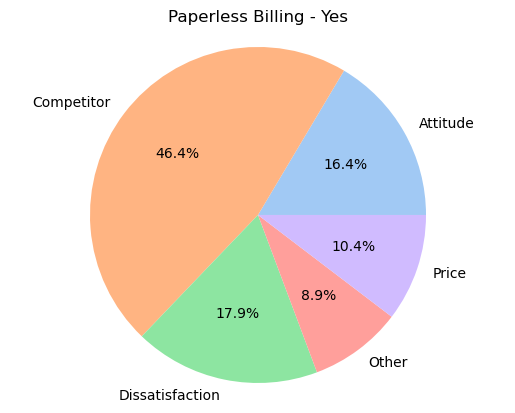

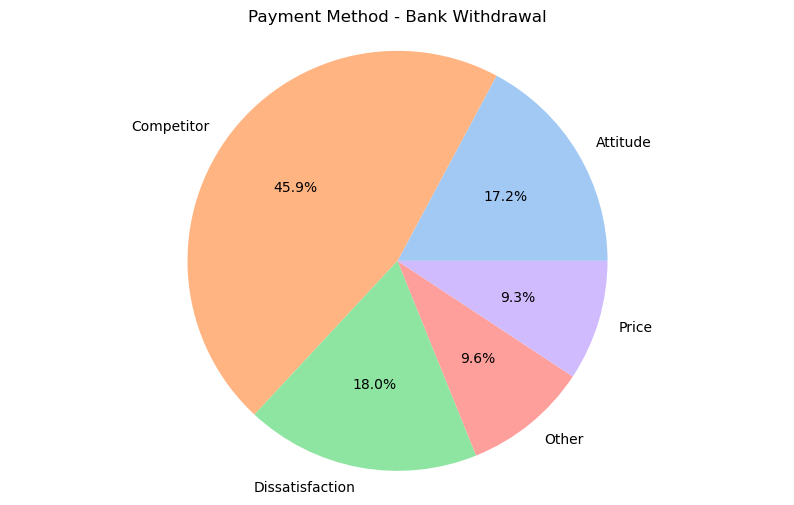

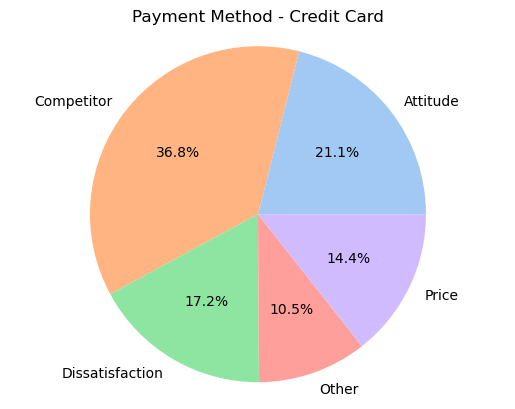

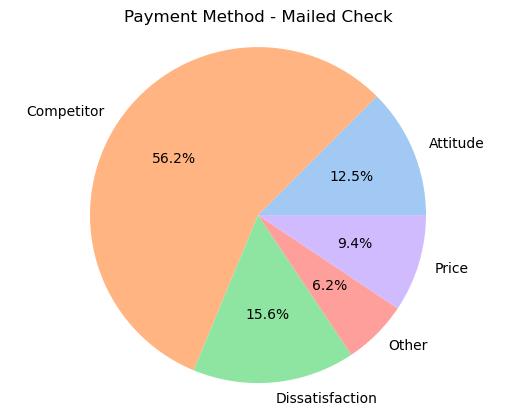

In [43]:
# Group by each categorical column and 'Churn Category', and get value counts for each category
for col in cat_cols_res:
    plt.figure(figsize=(10, 6))
    plt.title(f"Pie Chart for '{col}' - Comparison of Churn Categories")

    # Group the data by 'Churn Category' and the current column, and get value counts for each category
    group_counts = df_reason.groupby([col, 'Churn Category']).size().unstack()

    # Get the list of 'Churn Category' values
    churn_categories = group_counts.columns

    # Iterate through each category and plot the pie chart
    for category in group_counts.index:
        category_counts = group_counts.loc[category]
        plt.pie(category_counts, labels=churn_categories, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
        plt.title(f"{col} - {category}")
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()
